<a href="https://colab.research.google.com/github/supertime1/Floyer_Analysis/blob/main/Cosinuss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Set up dependency

In [1]:
import sys
sys.path.append('C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss')

In [79]:
from data_container import config, DataFile
from data_container.api_db_sync import DBSync
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import pickle
import seaborn as sns
from utils import util
import pingouin as pg
import scipy.stats

#2.Connect to Cosinuss Database

Connect to Cosinuss's database to get the API file handler. **Open redis-server.exe first before running configure_api()** .

In [3]:
# password: teeshau7aiMonoh9ee in case it is needed
api = util.configure_api('sonova_analysis', 'sonova.fremont.api', update_local=False)

2021-03-14 14:42:44 -  INFO -       dc_config: 226 - data_path is "C:\Users\57lzhang.US04WW4008\PycharmProjects\cosinuss\data"
2021-03-14 14:42:44 -  INFO -       dc_config: 141 - connect to database "sonova_analysis"
2021-03-14 14:42:44 -  INFO -       dc_config: 136 - init of data_container successful
2021-03-14 14:42:44 -  INFO -       api_login: 241 - login: sonova.fremont.api @ https://telecovid.earconnect.de
2021-03-14 14:42:45 -  INFO -       api_login: 253 - successful login, it expires 2021-03-15 02:42:44 expiring in 720.0 min


There are 164 files in local database


Generate a table from local local database by filtering the data with date

In [18]:
table = util.generate_table('2020-12-31', api)
print('There are', len(table), 'test records')
table.head()

There are 64 test records


,person,when,device,df id,duration,samples,cols,end
100,M9KH.BZYG (RaHe),2021-02-08 14:15:09,polar,1C2RATHBVH.C4CDEZ,1900-01-01 00:34:48,2.1 K,heart_rate,2021-02-08 14:49:57
101,M9KH.BZYG (RaHe),2021-02-08 14:15:14,cshell,1C2RATHBVH.38CD8K,1900-01-01 00:34:42,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_...",2021-02-08 14:49:56
102,M9KH.BZYG (RaHe),2021-02-08 14:15:23,cshell,1C2RATHBVH.LEMWKL,1900-01-01 00:34:36,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_...",2021-02-08 14:49:59
103,M9KH.BZYG (RaHe),2021-02-08 14:15:35,garmin,8QEK89R9B4.NZH5XL,1900-01-01 00:45:27,2.7 K,heart_rate,2021-02-08 15:01:02
104,M9KH.ME9A (LeLo),2021-02-08 15:23:00,polar,1C2RATHBVH.XCMFW1,1900-01-01 00:34:34,2.1 K,heart_rate,2021-02-08 15:57:34


Correct the label of 'cShell' and 'Biometric', in case they were mistakenly entered by Cosinuss

In [ ]:
# slow process, be careful to run it
correct_table = util.correct_label(table, api)

# save the table after running, so that you don't have to clean the label everytime
correct_table.to_pickle("C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss/local_db.pkl")

In [20]:
#load table from local directory if you've already done the label cleaning once
correct_table = pd.read_pickle("C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss/local_db.pkl")
correct_table.head()

,person,when,device,df id,duration,samples,cols,end
100,M9KH.BZYG (RaHe),2021-02-08 14:15:09,polar,1C2RATHBVH.C4CDEZ,1900-01-01 00:34:48,2.1 K,heart_rate,2021-02-08 14:49:57
101,M9KH.BZYG (RaHe),2021-02-08 14:15:14,cshell,1C2RATHBVH.38CD8K,1900-01-01 00:34:42,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_...",2021-02-08 14:49:56
102,M9KH.BZYG (RaHe),2021-02-08 14:15:23,biometric,1C2RATHBVH.LEMWKL,1900-01-01 00:34:36,1.7 M,"ppg_ir, ppg_ir_2, ppg_ir_3, ppg_...",2021-02-08 14:49:59
103,M9KH.BZYG (RaHe),2021-02-08 14:15:35,garmin,8QEK89R9B4.NZH5XL,1900-01-01 00:45:27,2.7 K,heart_rate,2021-02-08 15:01:02
104,M9KH.ME9A (LeLo),2021-02-08 15:23:00,polar,1C2RATHBVH.XCMFW1,1900-01-01 00:34:34,2.1 K,heart_rate,2021-02-08 15:57:34


Generate a statistic table for data analysis



In [ ]:
# find the row indices of paired floyer-polar device 
paired_idx_lst = util.find_pairs_row_index(correct_table, floyer_device='cshell')
# generate a paired sample class by using the paired row indices; 
# you also need to give the heart rate algorithm version
paired_sample_lst = util.generate_paired_samples(paired_idx_lst, 
                                                 correct_table, 
                                                 'v0',
                                                 api)
# save the paried sample list to save time on next run
with open("C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss/paired_sample_cshell.pkl", "wb") as fp:
    pickle.dump(paired_sample_lst, fp)

In [22]:
# load the paired_sample_lst if you've done it previously
with open("C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss/paired_sample_cshell.pkl", "rb") as fp:
    paired_sample_lst = pickle.load(fp)
    
paired_sample_lst

In [23]:
paired_sample_lst[0].floyer_hash_id

'1C2RATHBVH.38CD8K'

In [24]:
paired_sample_lst[0].header_floyer

<DataFile: DataFile(_hash_id=1C2RATHBVH.38CD8K, date_time_start=2021-02-08 14:15:14.693000+01:00, duration=2082.01, columns=8, slices=10, samples=1657080, file_size=4.3 MB)>

In [27]:
config.init(db_name='sonova_analysis')
api = DBSync(username='sonova.fremont.api',
                server='https://telecovid.earconnect.de')

2021-03-13 16:06:36 - ERROR -       dc_config:  53 - data_container.config.init() can only be called once
2021-03-13 16:06:37 -  INFO -       api_login: 241 - login: sonova.fremont.api @ https://telecovid.earconnect.de
2021-03-13 16:06:38 -  INFO -       api_login: 253 - successful login, it expires 2021-03-14 05:06:37 expiring in 780.0 min


In [28]:
api.one3_hr_algo('v0', '1C2RATHBVH.38CD8K')

2021-03-13 16:06:43 - ERROR -       api_login: 385 - https://telecovid.earconnect.de/api/v3/one3_hr_algo/v0/1C2RATHBVH.38CD8K/1/v0/1/IIR/0/6 failed with http code 404, route not found.


False

In [25]:
# generate a stats_table for stats analysis
stats_table = util.generate_stats_table(paired_sample_lst)
stats_table.head()

2021-03-13 16:02:13 - ERROR -       api_login: 385 - https://telecovid.earconnect.de/api/v3/one3_hr_algo/v0/1C2RATHBVH.38CD8K/1/v0/1/IIR/0/6 failed with http code 404, route not found.


1C2RATHBVH.38CD8K cannot be found


2021-03-13 16:02:13 - ERROR -       api_login: 385 - https://telecovid.earconnect.de/api/v3/one3_hr_algo/v0/1C2RATHBVH.G2HHR3/1/v0/1/IIR/0/6 failed with http code 404, route not found.


1C2RATHBVH.G2HHR3 cannot be found


2021-03-13 16:02:14 - ERROR -       api_login: 385 - https://telecovid.earconnect.de/api/v3/one3_hr_algo/v0/1C2RATHBVH.009DDE/1/v0/1/IIR/0/6 failed with http code 404, route not found.


1C2RATHBVH.009DDE cannot be found


2021-03-13 16:02:15 - ERROR -       api_login: 385 - https://telecovid.earconnect.de/api/v3/one3_hr_algo/v0/1C2RATHBVH.V5BXYZ/1/v0/1/IIR/0/6 failed with http code 404, route not found.


1C2RATHBVH.V5BXYZ cannot be found


2021-03-13 16:02:16 - ERROR -       api_login: 385 - https://telecovid.earconnect.de/api/v3/one3_hr_algo/v0/1C2RATHBVH.C0KF6Y/1/v0/1/IIR/0/6 failed with http code 404, route not found.


1C2RATHBVH.C0KF6Y cannot be found


2021-03-13 16:02:17 - ERROR -       api_login: 385 - https://telecovid.earconnect.de/api/v3/one3_hr_algo/v0/1C2RATHBVH.DYPFM1/1/v0/1/IIR/0/6 failed with http code 404, route not found.


1C2RATHBVH.DYPFM1 cannot be found


2021-03-13 16:02:18 - ERROR -       api_login: 385 - https://telecovid.earconnect.de/api/v3/one3_hr_algo/v0/1C2RATHBVH.JYKU22/1/v0/1/IIR/0/6 failed with http code 404, route not found.


1C2RATHBVH.JYKU22 cannot be found


2021-03-13 16:02:19 - ERROR -       api_login: 385 - https://telecovid.earconnect.de/api/v3/one3_hr_algo/v0/1C2RATHBVH.N74KKE/1/v0/1/IIR/0/6 failed with http code 404, route not found.


1C2RATHBVH.N74KKE cannot be found


2021-03-13 16:02:19 - ERROR -       api_login: 385 - https://telecovid.earconnect.de/api/v3/one3_hr_algo/v0/1C2RATHBVH.2E4QXX/1/v0/1/IIR/0/6 failed with http code 404, route not found.


1C2RATHBVH.2E4QXX cannot be found


2021-03-13 16:02:20 - ERROR -       api_login: 385 - https://telecovid.earconnect.de/api/v3/one3_hr_algo/v0/1C2RATHBVH.8HL047/1/v0/1/IIR/0/6 failed with http code 404, route not found.


1C2RATHBVH.8HL047 cannot be found


""


#3. Data Analysis

In [4]:
with open("C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss/stats.pkl", "rb") as fp:
    stats_table = pickle.load(fp)

In [28]:
def visualize_subjects(stats_table):
    """
    Check if each subject performs same activity with similar time span
    """
    time_span_lst = []
    activity_lst = []
    person_lst = []
    
    for person in np.unique(stats_table['person']):
        for activity in np.unique(stats_table['activity']):
            if activity == 'Unknown': continue
            temp_table = stats_table[(stats_table.person == person) &
                                     (stats_table.activity == activity)].reset_index()
            time_span_lst.append(len(temp_table))
            activity_lst.append(activity)
            person_lst.append(person)

    dic = {'time_span': time_span_lst,
           'activity': activity_lst,
           'person': person_lst
           }

    df = pd.DataFrame(data=dic, index=None)

    #plot activity vs time_span for each test subject
    g = sns.FacetGrid(df,
                      col='person',
                      col_wrap=1,
                      height=2,
                      aspect=5,
                      hue='activity'
                      )
    g = g.map(plt.bar, 'activity', 'time_span')
    axes = g.axes.flatten()
    person_lst = np.unique(df['person'])

    for i in range(len(axes)):
        axes[i].set_title("Person:  " + person_lst[i], fontsize=14)
    g.set_ylabels('Time_Span (s)', fontsize=14)
    g.set_xlabels('Activity', fontsize=14)
    plt.xticks(rotation=45, fontsize=14)
    plt.legend(bbox_to_anchor=(1.4, 5))
    return df

,time_span,activity,person
0,361,Chewing (chewing gum),M9KH.3WKY
1,589,Running 6km/h,M9KH.3WKY
2,600,Running 8km/h,M9KH.3WKY
3,371,Sitting,M9KH.3WKY
4,365,Sitting - Standing - Sitting,M9KH.3WKY
...,...,...,...
107,183,Sitting,M9KH.WSBV
108,182,Sitting - Standing - Sitting,M9KH.WSBV
109,181,Talking (read aloud),M9KH.WSBV
110,296,Walking 2km/h,M9KH.WSBV


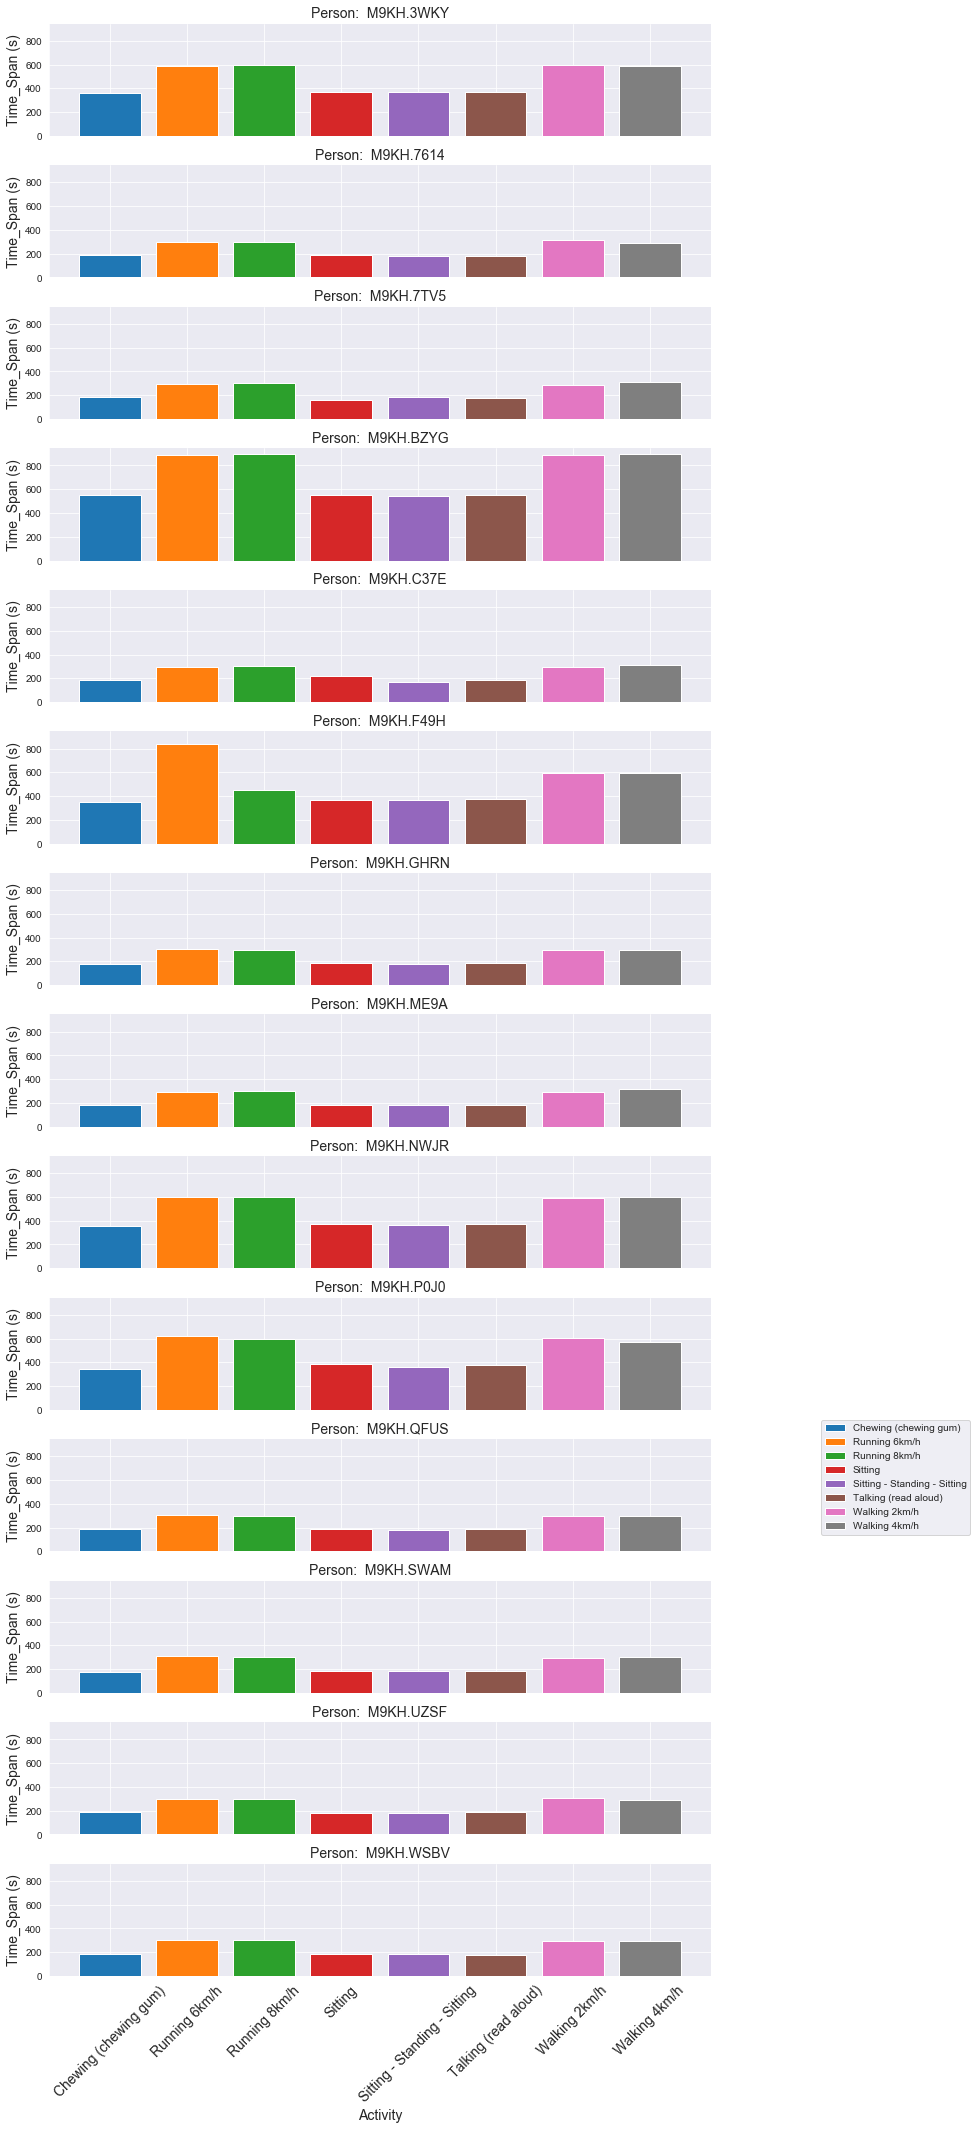

In [30]:
visualize_subjects(stats_table)

In [5]:
mape_df = util.create_mape_table(stats_table, quality_level=35)
mape_df.head()

,mape,da,activity,person
0,12.51,33.0,Chewing (chewing gum),M9KH.3WKY
1,15.25,40.0,Running 6km/h,M9KH.3WKY
2,6.41,48.0,Running 8km/h,M9KH.3WKY
3,4.23,90.0,Sitting,M9KH.3WKY
4,20.66,36.0,Sitting - Standing - Sitting,M9KH.3WKY


In [26]:
def plot_mape(mape_df, num_subject, device_type, algo_version, 
              qf_lvl, person_level=True):
    """
    Make MAPE boxplot
    """
    if not person_level:
        fig, ax = plt.subplots(1, 1, figsize=(12,8))
        ax.set_xticks(np.arange(0,100,10), minor=False)
        ax.grid(b=True, which='major', color='w', linewidth=2.0)
        ax.grid(b=True, which='minor', color='w', linewidth=1)

        sns.set_style('darkgrid')
        g = sns.boxplot(x='mape',
                        y='activity',
                        data=mape_df)
        plt.suptitle('Boxplot of MAPE per Activity', fontsize=24)
        plt.title(f'Num of Subjects = {num_subject},   Device = {device_type},\
   Algo_Version = {algo_version},   QF_lvl = {qf_lvl}', fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.xlabel('MAPE', fontsize=26)
        plt.ylabel('Activity', fontsize=26)

    else:
        g = sns.FacetGrid(mape_df,
                          col='person',
                          col_wrap=1,
                          height=2,
                          aspect=5,
                          hue='activity'
                          )
        g = g.map(plt.bar, 'activity', 'mape')
        axes = g.axes.flatten()
        person_lst = np.unique(mape_df['person'])

        for i in range(len(axes)):
            axes[i].set_title("Person:  " + person_lst[i], fontsize=14)
        g.set_ylabels('MAPE', fontsize=14)
        g.set_xlabels('Activity', fontsize=14)
        plt.xticks(rotation=45, fontsize=14)
        plt.legend(bbox_to_anchor=(1.4, 5))

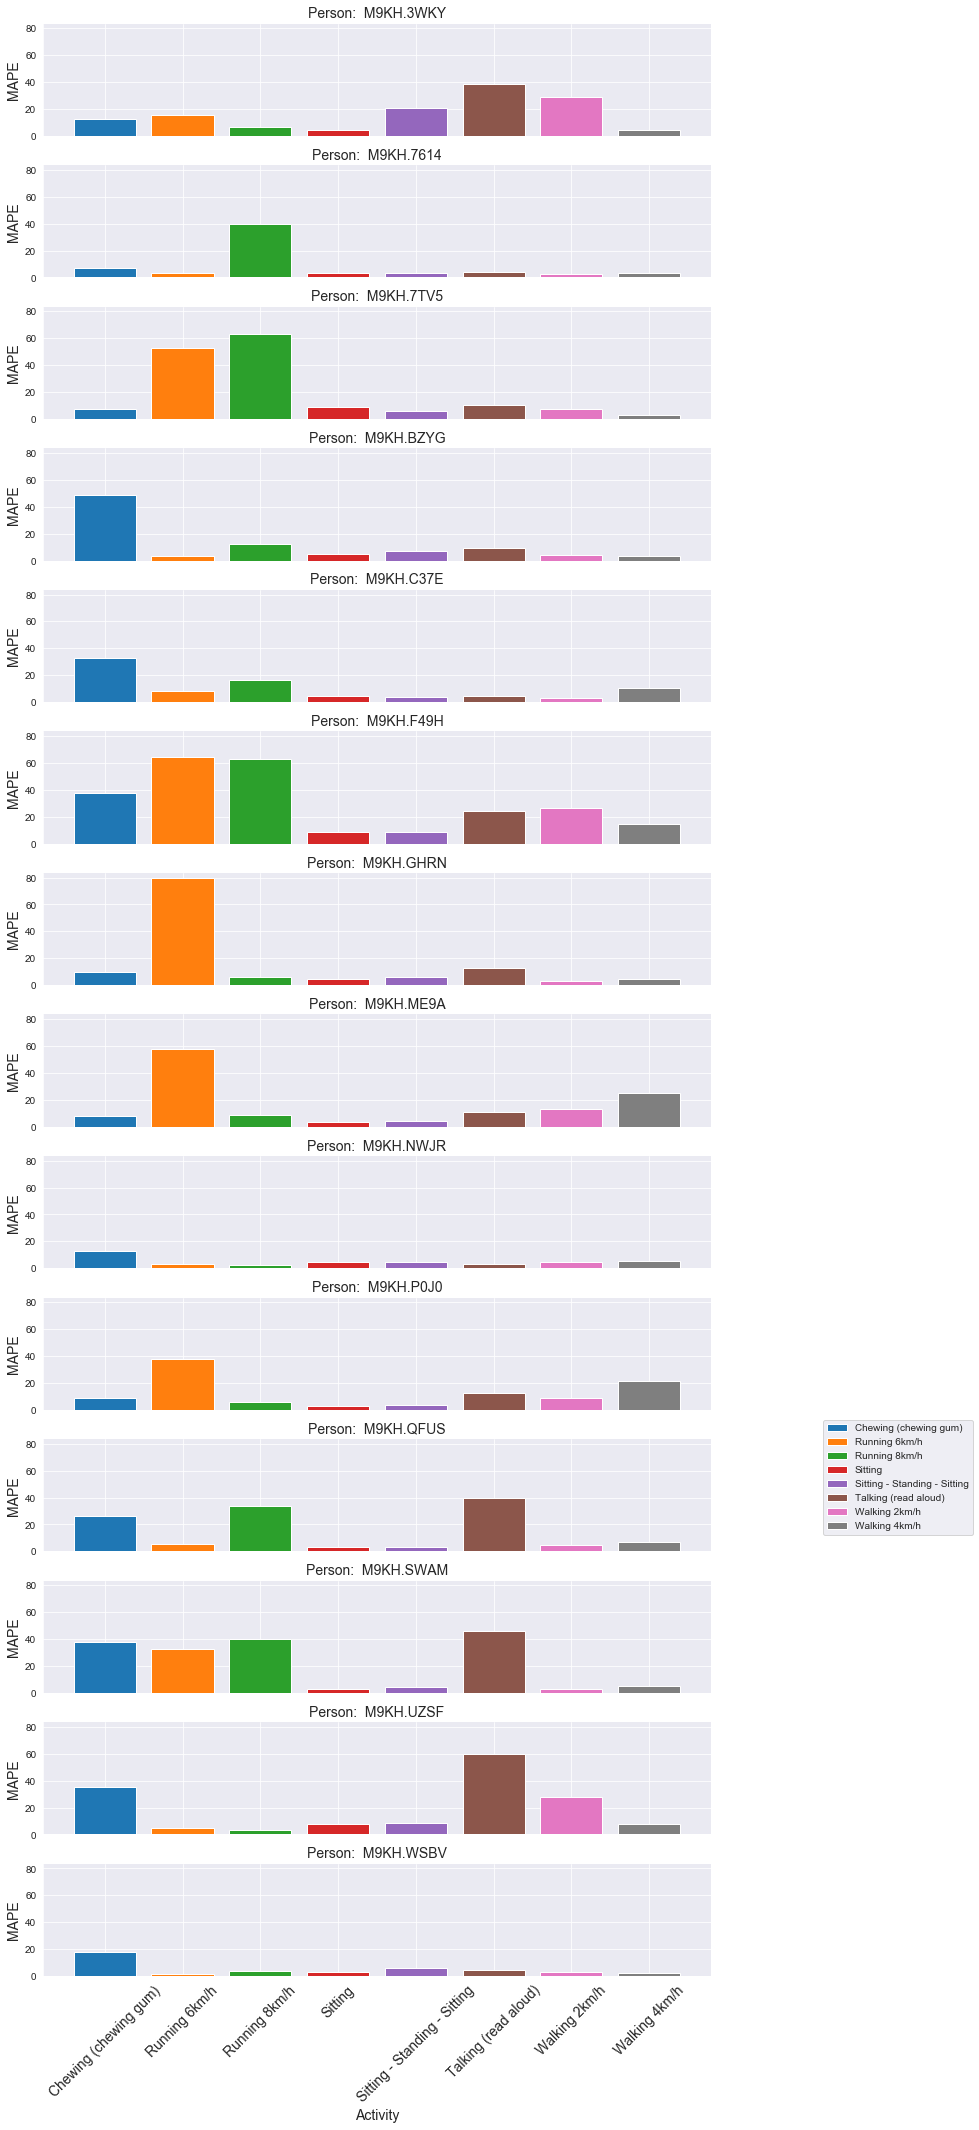

In [27]:
plot_mape(mape_df, '14', 'biometric', 'v0', '35', person_level=True)

In [10]:
def plot_da(mape_df, num_subject, device_type, algo_version, 
              qf_lvl, person_level=False):
    """
    Make MAPE boxplot
    """
    if not person_level:
        fig, ax = plt.subplots(1, 1, figsize=(12,8))
        ax.set_xticks(np.arange(0,100,10), minor=False)
        ax.grid(b=True, which='major', color='w', linewidth=2.0)
        ax.grid(b=True, which='minor', color='w', linewidth=1)
        
        sns.set_style('darkgrid')
        g = sns.boxplot(x='da',
                        y='activity',
                        data=mape_df)
        plt.suptitle('Boxplot of Data Availability per Activity', fontsize=24)
        plt.title(f'Num of Subjects = {num_subject},   Device = {device_type},\
   Algo_Version = {algo_version},   QF_lvl = {qf_lvl}', fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.xlabel('Data Availability', fontsize=26)
        plt.ylabel('Activity', fontsize=26)

    else:
        g = sns.FacetGrid(mape_df,
                          col='person',
                          col_wrap=1,
                          height=2,
                          aspect=5,
                          hue='activity'
                          )
        g = g.map(plt.bar, 'activity', 'da')
        axes = g.axes.flatten()
        person_lst = np.unique(mape_df['person'])

        for i in range(len(axes)):
            axes[i].set_title("Person:  " + person_lst[i], fontsize=14)
        g.set_ylabels('DA', fontsize=14)
        g.set_xlabels('Activity', fontsize=14)
        plt.xticks(rotation=45, fontsize=14)
        plt.legend(bbox_to_anchor=(1.4, 5))
        

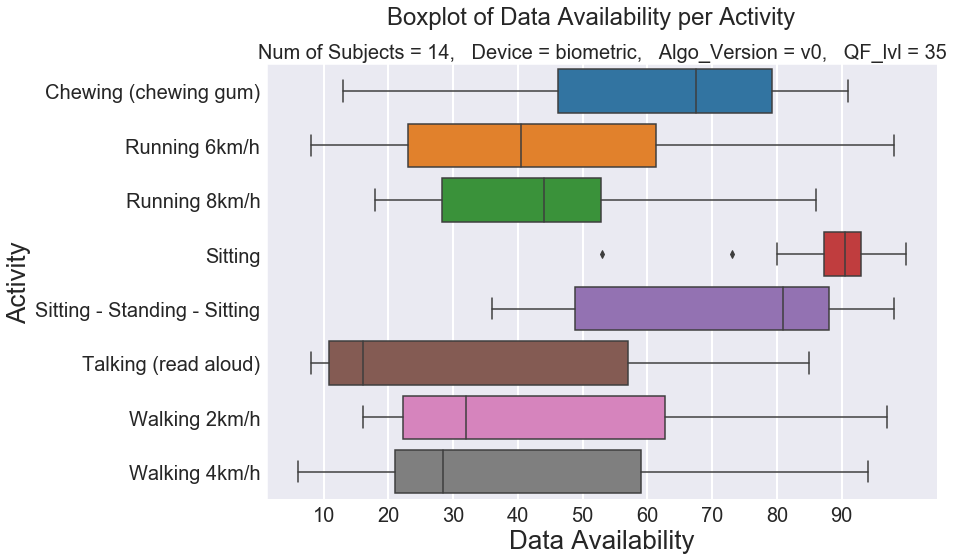

In [11]:
plot_da(mape_df, '14', 'biometric', 'v0', '35', person_level=False)

Make a DA vs MAPE

In [32]:
def generate_qa_table(stats_table):

    mape_lst = []
    mape_std_lst = []
    da_lst = []
    da_std_lst = []
    qa_lst = []
    activity_lst = []
    
    qa_range = [30, 35, 40, 45, 50, 55, 60, 65]

    for activity in np.unique(stats_table['activity']):
        if activity == 'Unknown': continue
        activity_table = stats_table[stats_table.activity == activity].reset_index()
        
        for qa in qa_range:
            temp_mape_lst = []
            temp_da_lst = []
            # calculate each person's mape and da, to get the mean and std of mape and da
            for person in np.unique(activity_table['person']):
                person_activity_table = activity_table[activity_table.person == person].reset_index()
                sum = 0
                count = 0
                for i in range(len(person_activity_table)):
                    if qa <= person_activity_table['quality'][i] <= 100:
                        sum += abs(person_activity_table['floyer_hr'][i] - 
                                   person_activity_table['polar_hr'][i]) / person_activity_table['polar_hr'][i] * 100
                        count += 1
                if count == 0: continue
                mape = round(sum / count, 2)
                da = round(count / len(person_activity_table) * 100, 2)
                temp_mape_lst.append(mape)
                temp_da_lst.append(da)
            
            mean_mape = np.mean(np.asarray(temp_mape_lst))
            std_mape = np.std(np.asarray(temp_mape_lst))
            mean_da = np.mean(np.asarray(temp_da_lst))
            std_da = np.std(np.asarray(temp_da_lst))

            mape_lst.append(mean_mape)
            mape_std_lst.append(std_mape)
            da_lst.append(mean_da)
            da_std_lst.append(std_da)
            qa_lst.append(qa)
            activity_lst.append(activity)

    dic = {'mape': mape_lst,
           'mape_std': mape_std_lst,
           'da': da_lst,
           'da_std': da_std_lst,
           'qa': qa_lst,
           'activity': activity_lst}   

    df = pd.DataFrame(data=dic, index=None)

    return df

In [33]:
df = generate_qa_table(stats_table)

Text(0.4, 1.05, 'Biometric (14x subject, algo = v0)')

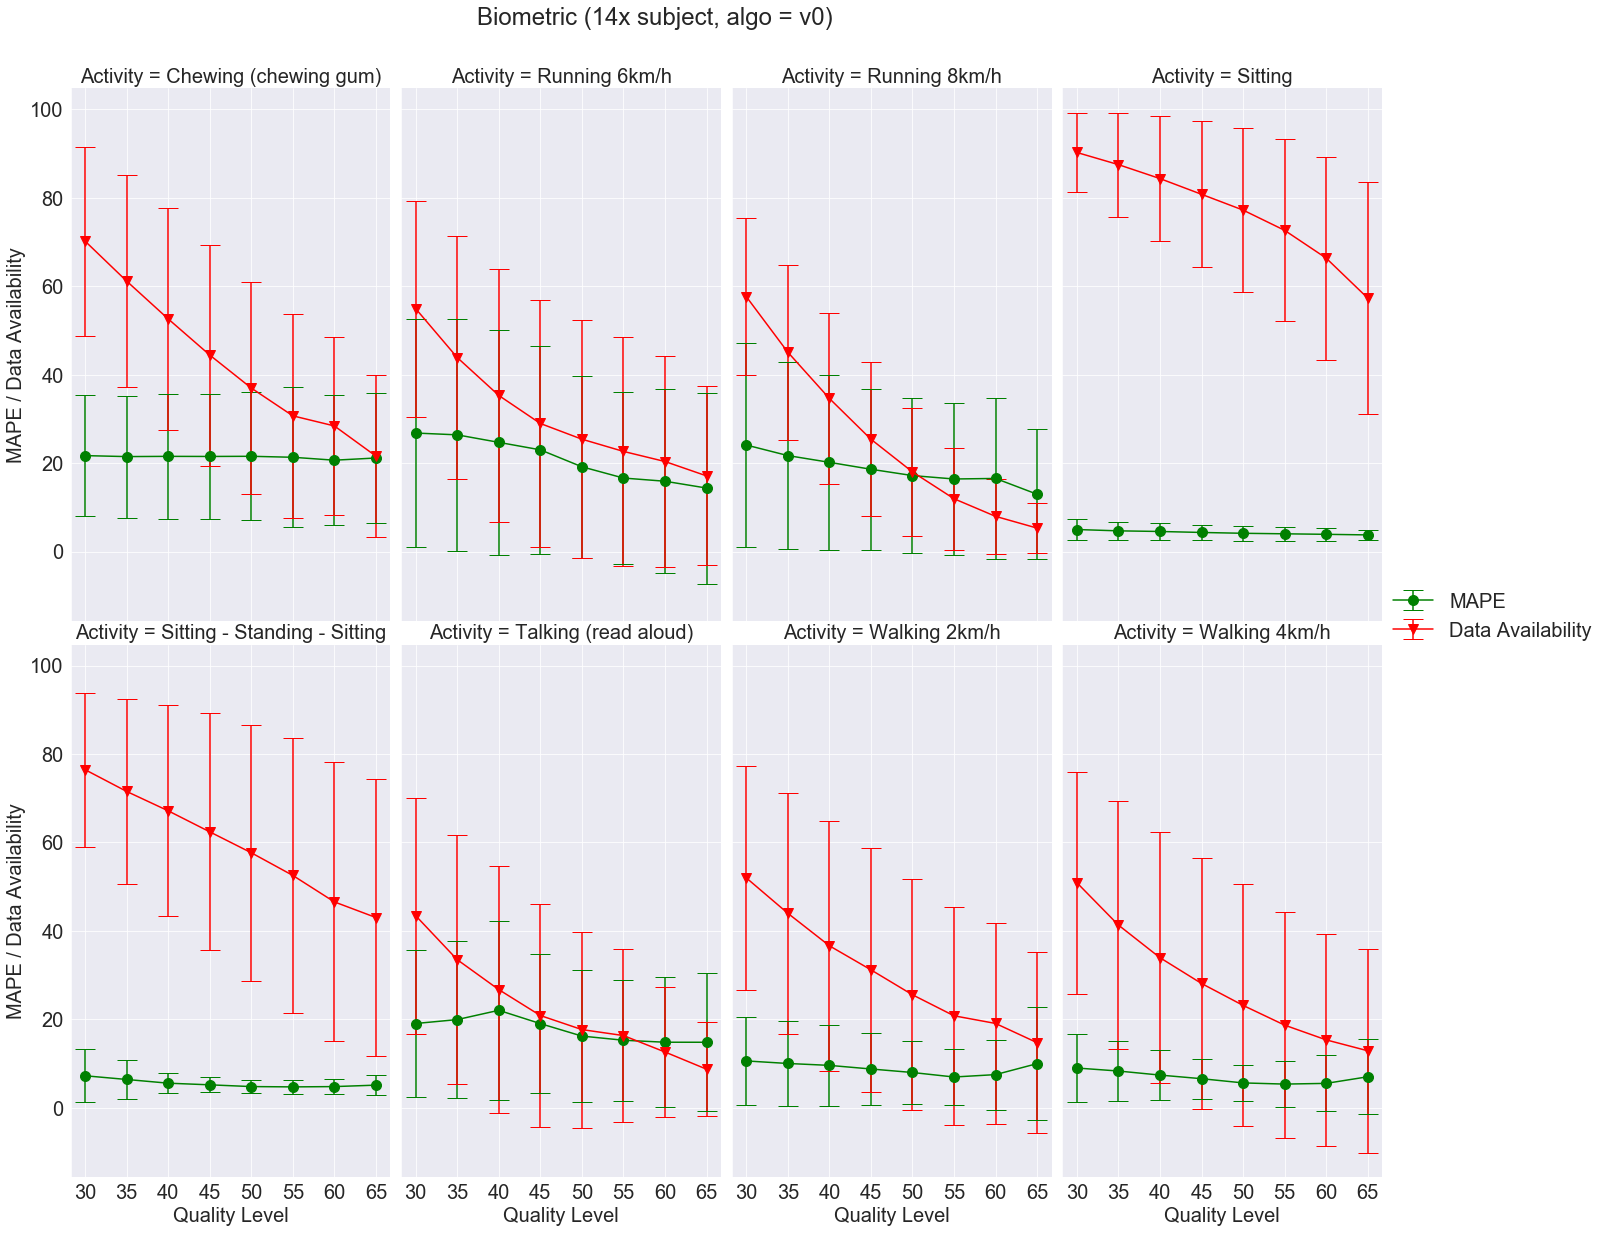

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
g = sns.FacetGrid(df,
                  col='activity',
                  col_wrap=4,
                  height=8,
                  aspect=0.6
                  )

g = g.map(plt.errorbar, 'qa', 'mape', 'mape_std', capsize=10, marker='o', ms=10, color='green', label='MAPE')
g = g.map(plt.errorbar, 'qa', 'da', 'da_std', capsize=10, marker='v', ms=10, color='red', label='Data Availability')
axes = g.axes.flatten()
activity_lst = np.unique(df['activity'])

for i in range(len(axes)):
    axes[i].set_title("Activity = " + activity_lst[i], fontsize=20)
g.set_yticklabels(fontsize=20)
g.set_xticklabels([25,30,35,40,45,50,55,60,65],fontsize=20)
g.set_ylabels('MAPE / Data Availability', fontsize=20)
g.set_xlabels('Quality Level', fontsize=20)
g.add_legend(fontsize=20)
plt.suptitle('Biometric (14x subject, algo = v0)', x=0.4, y=1.05, fontsize=24)

##Continue Here

In [90]:
#Make statistic table
def create_overview_table(stats_table, quality_level):
    """
    Create a table with all statistical metrics in it
    """
    activity_lst = []
    floyer_mean_lst = []
    floyer_std_lst = []
    polar_mean_lst = []
    polar_std_lst = []
    bias_mean_lst = []
    bias_loa_lst = []
    cor_lst = []
    mape_lst = []
    da_lst = []
    icc_lst = []


    # calculate limits of agreement of the mean of difference
    def mean_diff_loa(data):
        mean = np.mean(data)
        std = np.std(data)
        loa_high = mean + 1.96 * std
        loa_low = mean - 1.96 * std
        return [loa_high, loa_low]
    
    # conver heart rate table to icc table
    def convert_to_icc_df(temp_table):
        target_lst = []
        rater_lst = []
        score_lst = []

        for i in range(len(temp_table)):
            target_lst += [temp_table['person'][i], temp_table['person'][i]]
            rater_lst += ['floyer', 'polar']
            score_lst += [temp_table['floyer_hr'][i], temp_table['polar_hr'][i]]
        
        dic  = {'target': target_lst,
                'rater': rater_lst,
                'score': score_lst
                }

        icc_df = pd.DataFrame(dic)
        return icc_df

    for activity in np.unique(stats_table['activity']):
        if activity == 'Unknown': continue
        temp_table = stats_table[(stats_table.activity == activity)].reset_index()
  
        # calculate mape and da
        sum = 0
        count = 0
        for i in range(len(temp_table)):
            if quality_level <= temp_table['quality'][i] <= 100:
                sum += abs(temp_table['floyer_hr'][i] -
                           temp_table['polar_hr'][i]) / temp_table['polar_hr'][i] * 100
                count += 1
        mape = round(sum / count, 2)
        da = round(count / len(temp_table), 2) * 100  
        mape_lst.append(mape)
        da_lst.append(da)
        
        # calculate mean and std
        floyer_mean_lst.append(round(temp_table['floyer_hr'].mean()))
        polar_mean_lst.append(round(temp_table['polar_hr'].mean()))
        floyer_std_lst.append(round(temp_table['floyer_hr'].std()))
        polar_std_lst.append(round(temp_table['polar_hr'].std()))
        bias_mean_lst.append(round(np.mean(temp_table['floyer_hr'] - temp_table['polar_hr'])))
        bias_loa_lst.append(np.round(mean_diff_loa(temp_table['floyer_hr'] - temp_table['polar_hr'])))
        cor_lst.append(round(scipy.stats.pearsonr(temp_table['floyer_hr'], temp_table['polar_hr'])[0],2))
        

        icc = pg.intraclass_corr(data=convert_to_icc_df(temp_table), 
                                 targets='target', raters='rater',
                                 ratings='score').round(2)
        icc_lst.append(icc.set_index('Type')['ICC'][1])
            
        activity_lst.append(activity)

    dic = {'Activity': activity_lst,
           'Floyer Heart_Rate_mean': floyer_mean_lst,
           'Floyer Heart_Rate_std': floyer_std_lst,
           'Polar Heart_Rate_mean': polar_mean_lst,
           'Polar Heart_Rate_std': polar_std_lst,
           'Pearson Correlation': cor_lst,
           'Mean Difference (Bias)': bias_mean_lst,
           'Bias 95% LOA': bias_loa_lst,
           'MAPE': mape_lst,
           'DA (%)': da_lst, 
           'ICC': icc_lst
           }
        
    df = pd.DataFrame(data=dic, index=None)
    return df

overview_table = create_overview_table(stats_table, quality_level=35)
overview_table.style.set_table_styles

,Activity,Floyer Heart_Rate_mean,Floyer Heart_Rate_std,Polar Heart_Rate_mean,Polar Heart_Rate_std,Pearson Correlation,Mean Difference (Bias),Bias 95% LOA,MAPE,DA (%),ICC
0,Chewing (chewing gum),75,18,75,15,0.12,0,"[43.0, -43.0]",24.65,64.0,0.19
1,Running 6km/h,83,43,113,18,0.03,-30,"[61.0, -121.0]",14.41,46.0,0.14
2,Running 8km/h,112,47,139,20,0.31,-26,"[62.0, -115.0]",15.21,46.0,0.28
3,Sitting,68,16,72,16,0.84,-3,"[15.0, -21.0]",4.58,87.0,0.95
4,Sitting - Standing - Sitting,73,20,82,18,0.28,-9,"[36.0, -54.0]",6.07,72.0,0.52
5,Talking (read aloud),63,18,77,14,0.27,-14,"[25.0, -53.0]",10.38,37.0,0.22
6,Walking 2km/h,72,17,82,15,0.30,-10,"[27.0, -47.0]",8.10,44.0,0.43
7,Walking 4km/h,84,20,92,15,0.66,-7,"[23.0, -37.0]",5.94,44.0,0.76


In [ ]:
def make_ba_plot(stats_table):
    '''
    make_ba_plot for each activity
    '''

    


    g = sns.FacetGrid(ba_df,
                        col='person',
                        col_wrap=1,
                        height=2,
                        aspect=5,
                        hue='activity'
                        )
    g = g.map(plt.bar, 'activity', 'da')
    axes = g.axes.flatten()
    person_lst = np.unique(ba_df['person'])

    for i in range(len(axes)):
        axes[i].set_title("Person:  " + person_lst[i], fontsize=14)
    g.set_ylabels('DA', fontsize=14)
    g.set_xlabels('Activity', fontsize=14)
    plt.xticks(rotation=45, fontsize=14)
    plt.legend(bbox_to_anchor=(1.4, 5))
    